# Classification of News Article Subreddit Posts
### By Jamie McElhiney

## Problem Statement 

I am a member of a news agency that promotes our content on reddit. We want to post a breaking news story ASAP on the correct news subreddit so we can get exposure and traffic on our website since all posts on the subreddit are third party links. There are 2 main news subreddits r/worldnews and r/news that are very similar. There is no clear cut topic that separates these two subreddits. We don’t want to post the article on both subreddits and hope for the best since we can be marked for spam, leading to our article being deleted and a warning from reddit. We also want to uphold our reddit reputation as people call each other out for crossposting often.   
We are going to use these two subreddits, r/worldnews and r/news, to develop a classification model that will recommend which subreddit to post our breaking story to based on our title. We will develop three different classification models to classify our news article: LogisticRegression, Naive Bayes, and K-Nearest Neighbor. 

## Executive Summary

We are going to be using the subreddit data scraped by our data retrieval notebook which can be found [here](../project_3/p3_DataRetrieval.ipynb). The output csv can also be directly referenced [here](../project_3/datasets/subredditdata.csv). The dataframe is concatenated from two separate scraping queries targeting our two subreddits, r/news and r/worldnews. We are going to be developing a classification model based on the title of the subreddit post so we can determine which subreddit is most appropriate for our drafted news article. We used a regular expression tokenizer to remove unwanted characters from subreddit post titles. A stemmer was implemented after cleaning titles to find common root words and more efficiently recognize patterns within our corpus.  
So, If we are able to post the article to the more relevant subreddit, our post will receive more exposure leading to more traffic on our website and thus revenue from ads. Given the similar nature of the two subreddits, our task at hand is challenging and we did not receive many low bias models. The evaluation metric we will use in this case is accuracy, the number of correct predictions over the number of total predictions. We were able to develop a Multinomial Naive Bayes model with 65% accuracy. 

## Data

Data was scrapped from the two subreddits:  
[r/worldnews](https://www.reddit.com/r/worldnews/)  
[r/news](https://www.reddit.com/r/news/)  
For a more detailed look at our data, please check out the Data Dictionary located in the [ReadMe](../project_3)

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import requests
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

%matplotlib inline

# BEFORE RUNNING

Please run the data retrieval notebook to ensure the csv is in our datasets folder. You can run it [here](../project_3/p3_DataRetrieval.ipynb).

In [2]:
##Lets read in our data and drop the unnecessary columns 
news=pd.read_csv('./datasets/subredditdata.csv')
news.drop(['Unnamed: 0'],axis=1,inplace=True)

## EDA

In [3]:
##Lets get a sense of our data getting the shape and top 10 rows
print(news.shape)
news.head(10)

(5000, 8)


,title,subreddit,created_utc,author,num_comments,score,url,timestamp
0,"@akanmaja : Hey twitz_end ✍ 👽(@twitz_end), tha...",worldnews,1577917026,micladceo,0,1,https://mobile.twitter.com/akanmaja/status/121...,2020-01-01
1,Former NBA Commissioner David Stern Dead at 77,worldnews,1577917066,PinheadLarry2323,2,1,https://www.tmz.com/2020/01/01/nba-commissione...,2020-01-01
2,إسقاط طائرة تجسسية في محور جيزان تعتبر الخامسة...,worldnews,1577917176,almshhadalyemeni,0,1,http://www.almshhadalyemeni.net/132646/,2020-01-01
3,Is Uber Doomed to a Point of No Return?,worldnews,1577917185,Open_c_Source,2,1,https://medium.com/@waseemezzie/uber-the-next-...,2020-01-01
4,Zelensky's New Year address: Everyone should a...,worldnews,1577917681,Fanrific,3,1,https://www.unian.info/society/10816211-zelens...,2020-01-01
5,China's Social Credit System was set to be ful...,worldnews,1577918215,nomorepostypostyno,16,1,https://www.abc.net.au/news/2020-01-02/china-s...,2020-01-01
6,متجر Epic Games يفتتح العام الجديد بتوفير 3 أل...,worldnews,1577918484,5thaqafah,0,1,http://5thaqafah.blogspot.com/2020/01/epic-gam...,2020-01-01
7,Volunteers seek support dog missing from crash...,worldnews,1577918602,USNEWS01,0,1,https://for-hashtagsusa.blogspot.com/2020/01/v...,2020-01-01
8,Airbus beats goal with 863 jet deliveries in 2...,worldnews,1577918758,FortuitousAdroit,9,1,https://www.reuters.com/article/us-airbus-deli...,2020-01-01
9,الصواريخ والمسيرات يد طولى نحـــو ترسيخ النصر ...,worldnews,1577918969,almshhadalyemeni,0,1,http://www.almshhadalyemeni.net/132658/,2020-01-01


In [4]:
#remove unwanted strings from title column
news['title']=news['title'].map(lambda x: x.replace('http',''))
news['title']=news['title'].map(lambda x: x.replace('bit.ly',''))


In [5]:
##lets check out the data types of our columns
news.dtypes

title           object
subreddit       object
created_utc      int64
author          object
num_comments     int64
score            int64
url             object
timestamp       object
dtype: object

In [6]:
##Lets check if there are any nulls. Self text will be null since all of our posts are just links.
news.isnull().sum()

title           0
subreddit       0
created_utc     0
author          0
num_comments    0
score           0
url             0
timestamp       0
dtype: int64

In [7]:
#Lets set our timestamp data type to actual datetime data type just in case. 
news['timestamp']=pd.to_datetime(news['timestamp'])

### Pre-Processing/Feature Engineering

We can use a tokenizer to split our title, which is a string, into multiple substrings of just the words we want. We can use regular expression to include only alphanumerics, getting rid of unwanted words. 

In [8]:
tokenizer=RegexpTokenizer(r'\w+')##instantiate regeular expression tokenizer that returns only alphanumerics
p_stemmer=PorterStemmer()##instantiate stemmer

Stemming is a way of producing the root of a word. Such as 'operation' and 'operate' would both go to operat. We are going with stemming over lemmatizing in this case; it is a more crude method but will help with reducing features and recognizing trends. 

In [9]:
stemmed_title=[]##Create empty list to append stemmed title
for title in news['title']:##iterate through our title columns
    tokens=tokenizer.tokenize(title.lower())
    '''tokenize our LOWERCASE title since our computer knows the difference between
    upper and lower case so we want everything on the same case so our CountVec is more efficient'''
    stemmer=[p_stemmer.stem(token) for token in tokens]
    stemmed_title.append(" ".join(stemmer))##from lesson 5.03-nlp1
news['stemmed_title']=stemmed_title   

In [10]:
news.head(5)

,title,subreddit,created_utc,author,num_comments,score,url,timestamp,stemmed_title
0,"@akanmaja : Hey twitz_end ✍ 👽(@twitz_end), tha...",worldnews,1577917026,micladceo,0,1,https://mobile.twitter.com/akanmaja/status/121...,2020-01-01,akanmaja hey twitz_end twitz_end thank you for...
1,Former NBA Commissioner David Stern Dead at 77,worldnews,1577917066,PinheadLarry2323,2,1,https://www.tmz.com/2020/01/01/nba-commissione...,2020-01-01,former nba commission david stern dead at 77
2,إسقاط طائرة تجسسية في محور جيزان تعتبر الخامسة...,worldnews,1577917176,almshhadalyemeni,0,1,http://www.almshhadalyemeni.net/132646/,2020-01-01,إسقاط طائرة تجسسية في محور جيزان تعتبر الخامسة...
3,Is Uber Doomed to a Point of No Return?,worldnews,1577917185,Open_c_Source,2,1,https://medium.com/@waseemezzie/uber-the-next-...,2020-01-01,is uber doom to a point of no return
4,Zelensky's New Year address: Everyone should a...,worldnews,1577917681,Fanrific,3,1,https://www.unian.info/society/10816211-zelens...,2020-01-01,zelenski s new year address everyon should ans...


In [11]:
##We are going to get a stemmed word count bar chart of paired words so lets instantiate a count vectorizer for ths.
cvec=CountVectorizer(stop_words='english',ngram_range=(2,2))#we want pairs of words so ngram_range=(2,2)
v_text=cvec.fit_transform(news['stemmed_title'])#fit our count vectorizer to our stemmed title column
type(v_text)
news_sparse=pd.DataFrame(v_text.toarray(),columns=cvec.get_feature_names())
#we need to use .toarray() on our fit count vectorizer since it is still in matrix form

In [12]:
news_sparse.shape

(5000, 30143)

In [13]:
#Now lets make a data frame of our word pairs descending from most frequent to least. Grab the top 30. 
freq=pd.DataFrame(news_sparse.sum().sort_values(ascending=False).head(30),columns=['count'])

In [14]:
def word_freq(data,subreddit):## Lets make a function for a frequency graph since we are going to be using it a few times
    plt.figure(figsize=(10,10))
    sns.barplot(data=data,x='count',y=freq.index)
    plt.title(f'Paired Word Frequency ({subreddit})')
    plt.ylabel('Word Pairs')

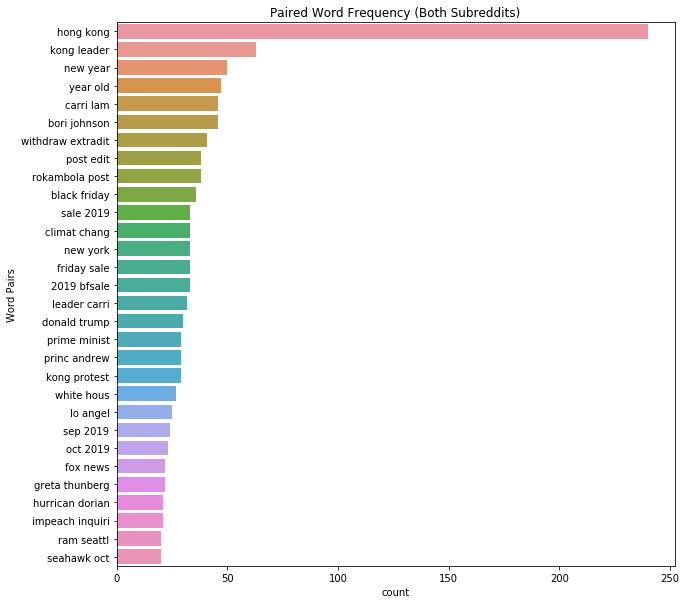

In [15]:
word_freq(freq,'Both Subreddits')

In [16]:
cvec=CountVectorizer(stop_words='english',ngram_range=(2,2))
v_text=cvec.fit_transform(news[news['subreddit']=='worldnews']['stemmed_title'])
news_sparse=pd.DataFrame(v_text.toarray(),columns=cvec.get_feature_names())

In [17]:
freq1=pd.DataFrame(news_sparse.sum().sort_values(ascending=False).head(30),columns=['count'])

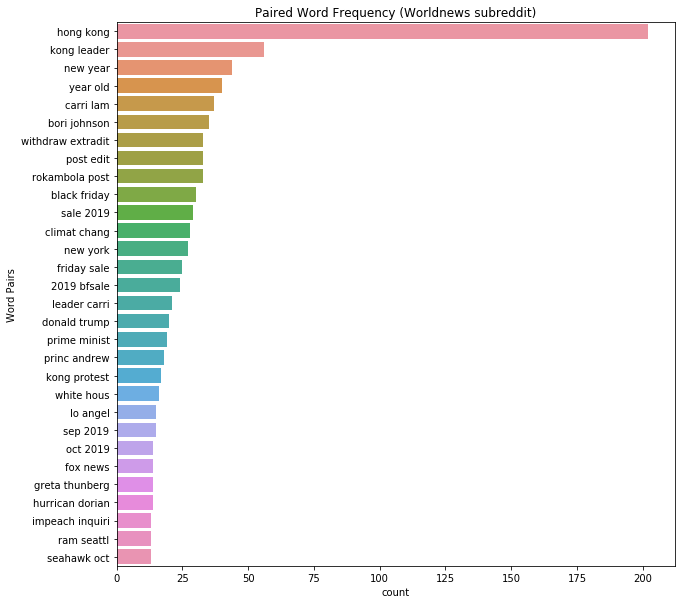

In [18]:
word_freq(freq1,'Worldnews subreddit')

In [19]:
cvec=CountVectorizer(stop_words='english',ngram_range=(2,2))
v_text=cvec.fit_transform(news[news['subreddit']=='news']['stemmed_title'])
news_sparse=pd.DataFrame(v_text.toarray(),columns=cvec.get_feature_names())

In [20]:
freq2=pd.DataFrame(news_sparse.sum().sort_values(ascending=False).head(30),columns=['count'])

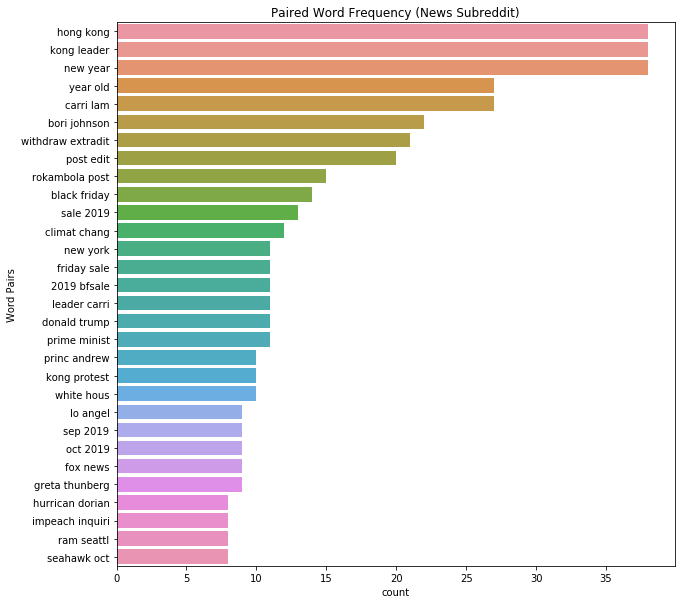

In [21]:
word_freq(freq2,'News Subreddit')

## Modeling

In [22]:
##Lets set up our y-variable. Setting subreddit worldnews to 1 and news to 0

In [23]:
news['subreddit']=news['subreddit'].map({'worldnews':1,'news':0})

In [24]:
y=news['subreddit']

In [25]:
#Lets see the class split. Totally even.
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [26]:
#Our X variable will be our stemmed title. 
X=news['stemmed_title']

### Baseline Model

In [27]:
#Our baseline model has an accuracy of 50% (the majority class)
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [28]:
#Lets get a train test split going, using random state 42
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

### Cvec-Logistic Regression Model

We are going to implement a gridsearch which we'll fit over multiple combinations of parameters. We will be using CountVectorizer on our subreddit title to count our stemmed words, and then using logistic regression as our classifier. We will GridSearch over max features, ngram range and stopwords for our CountVectorizer parameters. We will also search over our logistic penalty (ridge or lasso) and our alpha penalty coefficient (inverse C). 

In [29]:

pipe1=Pipeline([('cvec',CountVectorizer()),('lr',LogisticRegression(solver='liblinear'))])
pipe_params1={
    'cvec__max_features':[10,50],
    'cvec__ngram_range':[(1,1),(1,2)],
    'cvec__stop_words':['english',None],
     'lr__penalty':['l1','l2'],
     'lr__C':[0.01,0.1,1,10]
}

In [30]:
gs1=GridSearchCV(pipe1,pipe_params1,scoring='accuracy',cv=5)
#We will use accuracy as our scoring metric, and set cv=5

In [31]:
gs1=gs1.fit(X_train,y_train)
gs1.best_params_


{'cvec__max_features': 50,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'lr__C': 10,
 'lr__penalty': 'l1'}

We can see above which parameters gave us our best accuracy score. 

In [32]:
print(gs1.score(X_train,y_train))
print(gs1.score(X_test,y_test))

0.6469333333333334
0.6336


Seemingly high bias, and low variance for our first logistic regression

### Tfidf-Logistic Regression Model

Now we will use our TfidfVectorizer vectorizer which gives a score as opposed to a count based on the relative appearance of each vectorized word. 

In [33]:
pipe2=Pipeline([('tvec',TfidfVectorizer()),('lr',LogisticRegression(solver='liblinear'))])
pipe_params2={
    'tvec__max_features':[10,50],
    'tvec__ngram_range':[(1,1),(1,2)],
    'tvec__stop_words':['english',None],
     'lr__penalty':['l1','l2'],
     'lr__C':[0.01,0.1,10,100]
}

In [34]:
gs2=GridSearchCV(pipe2,pipe_params2,scoring='accuracy',cv=5)

In [35]:
gs2=gs2.fit(X_train,y_train)
gs2.best_params_

{'lr__C': 100,
 'lr__penalty': 'l1',
 'tvec__max_features': 50,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

Parameters are slightly difference, ngram_range is (1,1) and our alpha is 0.1 

In [36]:
print(gs2.score(X_train,y_train))
print(gs2.score(X_test,y_test))

0.6402666666666667
0.636


Our scores improved!

### Multinomial Naive Bayes Model

Third model we are going to use a Multinomial Naive Bayes. We have to set it up with CountVectorizer since MNB classifiers only accept positive integers so Tfidf is out of the question. 

In [37]:
pipe3=Pipeline([('cvec',CountVectorizer()),('mnb',MultinomialNB())])
pipe_params3={'cvec__max_features':[100,500],
            'cvec__ngram_range':[(1,1),(1,2)],
             'cvec__stop_words':['english',None]}

In [38]:
gs3=GridSearchCV(pipe3,pipe_params3,scoring='accuracy',cv=5)

In [39]:
gs3.fit(X_train,y_train)
gs3.best_params_

{'cvec__max_features': 500,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [40]:
print(gs3.score(X_train,y_train))
print(gs3.score(X_test,y_test))

0.7138666666666666
0.6576


This is our high scoring model yet. Relatively low bias and relatively low variance. 

### k-Nearest Neighbor Model

Last model we will look at is a k-Nearest Neighbor model. 

In [41]:
pipe4=Pipeline([('cvec',CountVectorizer()),('knn',KNeighborsClassifier())])
pipe_params4={'cvec__max_features':[100,500],
            'cvec__ngram_range':[(1,1),(1,2)],
             'cvec__stop_words':['english',None],
             'knn__n_neighbors':[3,5,7]}

We'll look at 3 different neighbor values, odd values mainly since we dont want to end up with a tie. 

In [42]:
gs4=GridSearchCV(pipe4,pipe_params4,scoring='accuracy',cv=5)

In [43]:
gs4.fit(X_train,y_train)
gs4.best_params_

{'cvec__max_features': 100,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'knn__n_neighbors': 7}

In [44]:
print(gs4.score(X_train,y_train))
print(gs4.score(X_test,y_test))

0.6725333333333333
0.6048


Pretty high variance, we dont want to use this model . 

|Model|Vectorizer|Train Score|Test Score|
|---|---|---|---|
|Logistic|cVec|0.6397|0.6344|
|Logistic|tVec|0.648|0.6392|
|kNN|cVec|0.6824|0.5568|
|MNB|cVec|0.7112|0.6824|

Looking at our model score chart, it seems pretty clear our highest performing model was our Multinomial Naive Bayes model. Lets look further into it with some evaluation metrics and graphs.

## Model Evaluation

### Confusion Matrix

We are going to be evaluating our best model, Multinomal Naive Bayes

In [45]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
#AND 
#https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

In [46]:
y_pred=gs3.predict(X_test)

In [47]:
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [48]:
TN,FP,FN,TP=confusion_matrix(y_test,y_pred).ravel()

Setting up our confusion matrix. .ravel() just returns the 2x2 matrix as a 1D array so we can assign our metrics easily.

In [49]:
print(f'TN = {TN}')

TN = 464


In [50]:
cm = confusion_matrix(y_test, y_pred)

In [51]:
import matplotlib

[Text(0, 0.5, 'news'), Text(0, 1.5, 'worldnews')]

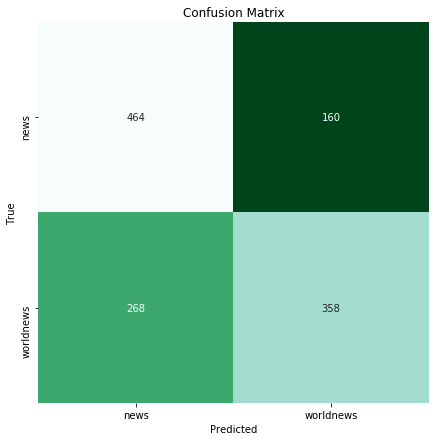

In [52]:
plt.figure(figsize=(7,7))
ax=plt.subplot()
akws = {'ha': 'center','va': 'center'}
sns.heatmap(cm, annot=True, cbar=False,ax = ax,fmt='1g',
            annot_kws=akws,cmap='BuGn_r'
            
            
           ); #annot=True to annotate cells
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['news','worldnews']) 
ax.yaxis.set_ticklabels(['news','worldnews'])


Confusion Matrix) We have worldnews subreddit set up with value 1 and news set up with 0 so our Positive is worldnews and our Negative is news. So our True Positives, 399 , is the number of times our MNB correctly predicted the post was in world news. Our True Negatives, 454, is the number of times our MNB correctly predicted the post was in news. Our False Positives, 170, is the number of times our MNB predicted worldnews when it was news. and False Negatives, 227, is the number of times news was predicted when it was worldnews. 

Lets Calculate Some Metrics:

In [53]:
print(f'Sensitivity = {TP/(TP+FN)}')
print(f'Specificity = {TN/(TN+FP)}')
print(f'Accuracy = {(TP+TN)/(TN+FP+TP+FN)}')
print(f'Missclassification = {(FP+FN)/(TN+FP+TP+FN)}')

Sensitivity = 0.5718849840255591
Specificity = 0.7435897435897436
Accuracy = 0.6576
Missclassification = 0.3424


In [54]:
Sensitivity=TP/(TP+FN)

In [55]:
Specificity=TN/(TN+FP)

## ROC Curve

In [56]:
##Used 4.04-lesson-classification-metrics-ii ROC curve example

In [57]:
pred_proba=[i[1] for i in gs3.predict_proba(X_test)]

In [58]:
pred_df=pd.DataFrame({'true_values':y_test,'pred_probs':pred_proba})

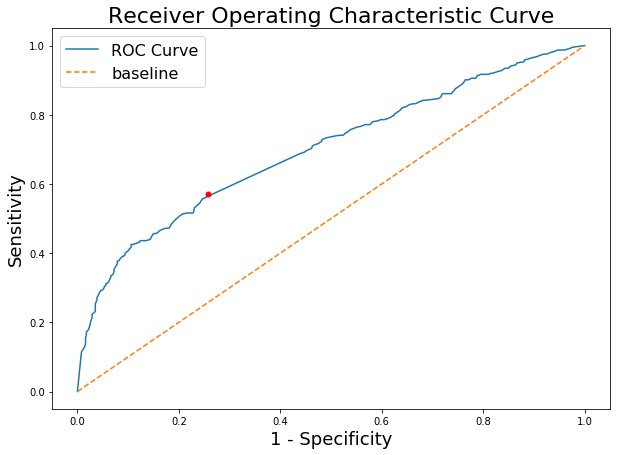

In [59]:
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.


plt.legend(fontsize=16)
#Get optimal point
plt.plot([1-Specificity], [Sensitivity], marker='o', markersize=5, color="red")


In [60]:
roc_auc_score(pred_df['true_values'],pred_df['pred_probs'])

0.6992645101171459

ROC Curve) Our ROC Curve represents the trade off between Specificity and Sensitivity. If we arent emphasizing these metrics (we arent) and want to maximize these two metric which will optimize our class separation.  We want the point along the curve that is closest to y=1, which is marked on the above graph. If our curve reaches y=1, this means our class distributions do not overlap at all. Given our AUC is .7235, this is mediocre and we expect to see some decent overlap in our pdistribution. 

## P-Distribution

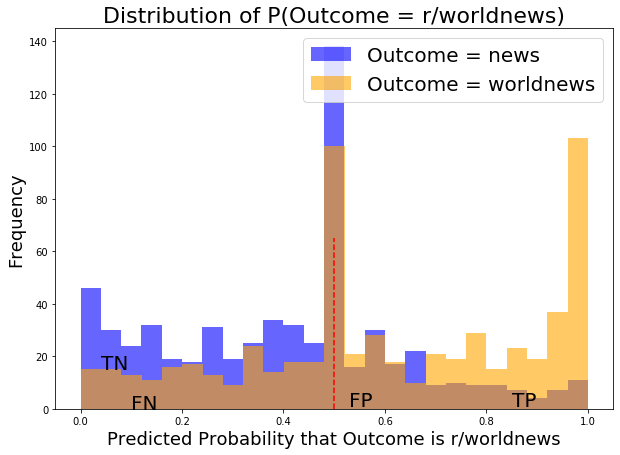

In [61]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = news')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = worldnews')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 15),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.1, 0),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.85, 1),
             s = 'TP',
             size = 20)

plt.annotate(xy = (0.53, 1),
             s = 'FP',
             size = 20)

# Label axes.
plt.title('Distribution of P(Outcome = r/worldnews)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome is r/worldnews', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

Probability Distribution) Above we can see the distributions of probability that the outcome is 1 (r/worldnews). We can also clearly see our TP,FN,FP, and TPs which gives of a better sense of how our model did. We can see that there is a ton of overlap, as we predicted by our ROC curve. there is resemblance of mediocre classification, but it does seem very muddled. 

## Conclusion and Recommendations

After evaluating our models, we came to the conclusion that our Multinomial Naive Bayes had relatively low bias and low variance. It also had an accuracy score of 0.65 which, in the context of the problem, is not half bad. To reiterate, these subreddits are super similar. I wanted to attempt this problem statement to see if there was something I was missing all this time as to why there are two major news subreddits that seemingly post the same content. I cannot confidently say that this is a strong classifier in the context of the problem. I would recommend using it as an initial guess as to where to post an article but to also use some basic intuition when delpoying this specific model.    
Some additional features I could add would be to access the article text by creating a soup object from the html, and appending the body text to the subreddit dataframe. Then from there vectorize and run classification.  